In [26]:
!pip install rasterio
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install torchmetrics

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import math

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import albumentations as A

import segmentation_models_pytorch as smp

import torchmetrics as tm

import rasterio as rio
from rasterio.plot import show

In [27]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [28]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [29]:
all_files = list_files('/content/drive/MyDrive/GIS_ML/test_dataset/Chips/')
image_list = [file for file in all_files if ('Feature' in file)]
mask_list = [file for file in all_files if ('Mask' in file)]

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print(image_list, mask_list)

['/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature1_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature2_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature3_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature4_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Feature1_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Feature2_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Feature3_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Feature4_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2018/Feature1_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2018/Feature2_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2018/Feature3_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2018/Feature4_1.tif', '/content/drive/MyDrive/GIS

In [30]:
SPLITTED_DATA = '/content/splitted'
os.makedirs(SPLITTED_DATA, exist_ok = True)

In [31]:
df = pd.DataFrame(list(zip(image_list, mask_list)),
                  columns=['image_path','mask_path'])

In [32]:
df.head()

,image_path,mask_path
0,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
1,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
2,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
3,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
4,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...


In [33]:
train = df.sample(frac=0.7,random_state=101)
leftovers = df.drop(train.index)
test = leftovers.sample(frac=0.5,random_state=101)
val = leftovers.drop(test.index)

In [34]:
print(len(train),len(test),len(val))

80 17 17


In [35]:
train.to_csv(SPLITTED_DATA+"/mytrain.csv", index=False)
test.to_csv(SPLITTED_DATA+"/mytest.csv", index=False)
val.to_csv(SPLITTED_DATA+"/myval.csv", index=False)

In [217]:
train = pd.read_csv(SPLITTED_DATA+"/mytrain.csv")
test = pd.read_csv(SPLITTED_DATA+"/mytest.csv")
val = pd.read_csv(SPLITTED_DATA+"/myval.csv")

In [218]:
# Subclass and define custom dataset ===========================
class AlbaniaDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx, 0]
        mask_name = self.df.iloc[idx, 1]
        image_source = rio.open(image_name)
        image = image_source.read()
        image_source.close
        image = image[[1,2,3,4,5,6,7,8,9,10,11,12],:,:]
        mask_source = rio.open(mask_name)
        mask = mask_source.read()
        mask_source.close()
        image = image.astype('float32')
        mask = mask.astype('float32')

        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image.copy())
            mask = torch.from_numpy(mask.copy())
            image = image.float()/255
            mask = mask.float()
            mask = mask.squeeze().long()
        else:
            image = torch.from_numpy(image.copy())
            mask = torch.from_numpy(mask.copy())
            image = image.float()/255
            mask = mask.float()
            mask = mask.squeeze().long()
        return image, mask
    def __len__(self):
        return len(self.df)

In [219]:
train_transform = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [220]:
train_dataset = AlbaniaDataset(train, transform=train_transform)
validation_dataset = AlbaniaDataset(val, transform=None)
print("Number of Training Samples: " + str(len(train_dataset)) + " Number of Validation Samples: " + str(len(validation_dataset)))

Number of Training Samples: 80 Number of Validation Samples: 17


In [221]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=0, drop_last=True)

In [222]:
encoder = "resnet18"
encoder_weights = None
activation = None

In [223]:
model = smp.DeepLabV3Plus(
    encoder_name=encoder,
    encoder_weights=encoder_weights,
    classes=2,
    activation=activation,
)

In [224]:
model.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [225]:
model = model.to(device)

In [226]:
next(model.parameters()).is_cuda

True

In [227]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [237]:
acc = tm.Accuracy(task="multiclass", average="macro", num_classes=2).to(device)
f1 = tm.F1Score(task="multiclass", average="macro", num_classes=2).to(device)
kappa = tm.CohenKappa(task="multiclass", average = "macro", num_classes=2).to(device)

In [238]:
epochs = 50
saveFolder = ""

In [239]:
#https://github.com/qubvel/segmentation_models.pytorch/issues/79
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False
    return

def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True
    return

In [240]:
eNum = []
t_loss = []
t_acc = []
t_f1 = []
t_kappa = []
v_loss = []
v_acc = []
v_f1 = []
v_kappa = []

f1VMax = 0.0

# Loop over epochs
for epoch in range(1, epochs+1):
    # Loop over training batches
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Get data and move to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()
        # Predict data
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, targets)

        # Calculate metrics
        accT = acc(outputs, targets)
        f1T = f1(outputs, targets)
        kappaT = kappa(outputs, targets)

        # Backpropagate
        loss.backward()

        # Update parameters
        optimizer.step()

    # Accumulate metrics at end of training epoch
    accT = acc.compute()
    f1T = f1.compute()
    kappaT = kappa.compute()

    # Print Losses and metrics at end of each training epoch
    print(f'Epoch: {epoch}, Training Loss: {loss.item():.4f}, Training Accuracy: {accT:.4f}, Training F1: {f1T:.4f}, Training Kappa: {kappaT:.4f}')

    # Append results
    eNum.append(epoch)
    t_loss.append(loss.item())
    t_acc.append(accT.detach().cpu().numpy())
    t_f1.append(f1T.detach().cpu().numpy())
    t_kappa.append(kappaT.detach().cpu().numpy())

    # Reset metrics
    acc.reset()
    f1.reset()
    kappa.reset()

    # loop over validation batches
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validation_dataloader):
            # Get data and move to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Predict data
            outputs = model(inputs)
            # Calculate validation loss
            loss_v = criterion(outputs, targets)

            # Calculate metrics
            accV = acc(outputs, targets)
            f1V = f1(outputs, targets)
            kappaV = kappa(outputs, targets)

    # Accumulate metrics at end of validation epoch
    accV = acc.compute()
    f1V = f1.compute()
    kappaV = kappa.compute()

    # Print validation loss and metrics
    print(f'Validation Loss: {loss_v.item():.4f}, Validation Accuracy: {accV:.4f}, Validation F1: {f1V:.4f}, Validation Kappa: {kappaV:.4f}')

    # Append results
    v_loss.append(loss_v.item())
    v_acc.append(accV.detach().cpu().numpy())
    v_f1.append(f1V.detach().cpu().numpy())
    v_kappa.append(kappaV.detach().cpu().numpy())

    # Reset metrics
    acc.reset()
    f1.reset()
    kappa.reset()

    # Save model if validation F1-score improves
    f1V2 = f1V.detach().cpu().numpy()
    if f1V2 > f1VMax:
        f1VMax = f1V2
        torch.save(model.state_dict(), saveFolder + 'Albania_model_Dlv3p.pt')
        print(f'Model saved for epoch {epoch}.')

Epoch: 1, Training Loss: 0.1257, Training Accuracy: 0.6494, Training F1: 0.7128, Training Kappa: 0.4303
Validation Loss: 0.0564, Validation Accuracy: 0.9177, Validation F1: 0.8684, Validation Kappa: 0.7369
Model saved for epoch 1.
Epoch: 2, Training Loss: 0.1145, Training Accuracy: 0.7149, Training F1: 0.7801, Training Kappa: 0.5621
Validation Loss: 0.0576, Validation Accuracy: 0.9200, Validation F1: 0.8699, Validation Kappa: 0.7398
Model saved for epoch 2.
Epoch: 3, Training Loss: 0.0643, Training Accuracy: 0.6895, Training F1: 0.7581, Training Kappa: 0.5191
Validation Loss: 0.0508, Validation Accuracy: 0.9374, Validation F1: 0.8656, Validation Kappa: 0.7314
Epoch: 4, Training Loss: 0.1950, Training Accuracy: 0.6504, Training F1: 0.7157, Training Kappa: 0.4362
Validation Loss: 0.0516, Validation Accuracy: 0.9420, Validation F1: 0.8809, Validation Kappa: 0.7619
Model saved for epoch 4.
Epoch: 5, Training Loss: 0.2793, Training Accuracy: 0.6783, Training F1: 0.7454, Training Kappa: 0.49

In [241]:
SeNum = pd.Series(eNum, name="epoch")
St_loss = pd.Series(t_loss, name="training_loss")
St_acc = pd.Series(t_acc, name="training_accuracy")
St_f1 = pd.Series(t_f1, name="training_f1")
St_kappa = pd.Series(t_kappa, name="training_kappa")
Sv_loss = pd.Series(v_loss, name="val_loss")
Sv_acc = pd.Series(v_acc, name="val_accuracy")
Sv_f1 = pd.Series(v_f1, name="val_f1")
Sv_kappa = pd.Series(v_kappa, name="val_kappa")
resultsDF = pd.concat([SeNum, St_loss, St_acc, St_f1, St_kappa, Sv_loss, Sv_acc, Sv_f1, Sv_kappa], axis=1)

In [242]:
resultsDF.to_csv(saveFolder+"resultsTopoDL.csv")

In [243]:
resultsDF = pd.read_csv(saveFolder+"resultsTopoDL.csv")

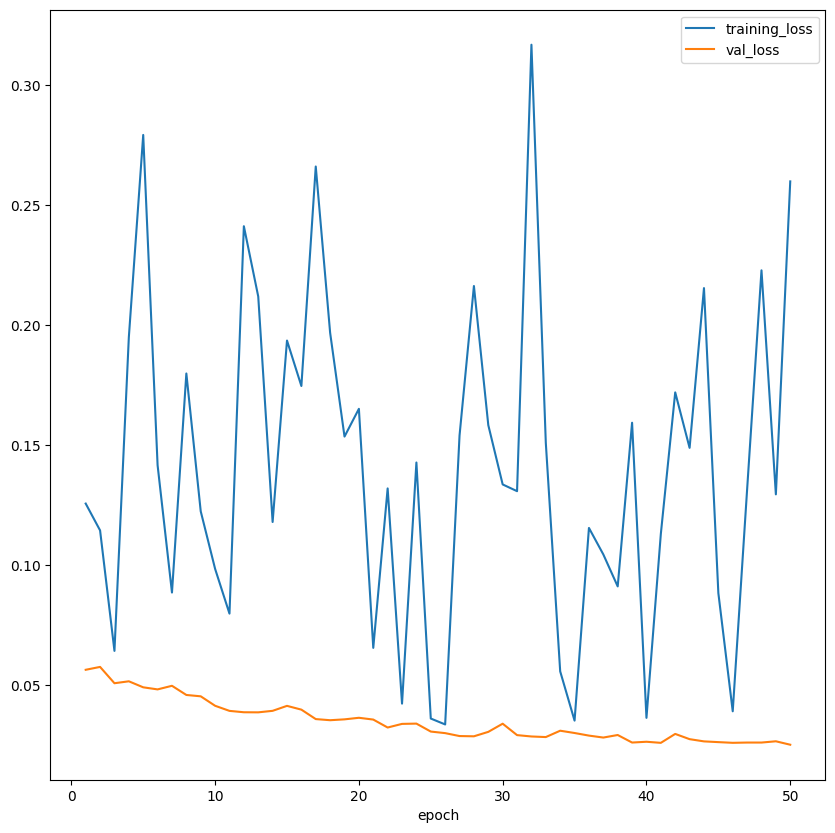

In [244]:
plt.rcParams['figure.figsize'] = [10, 10]
firstPlot = resultsDF.plot(x='epoch', y="training_loss")
resultsDF.plot(x='epoch', y="val_loss", ax=firstPlot)
plt.show()

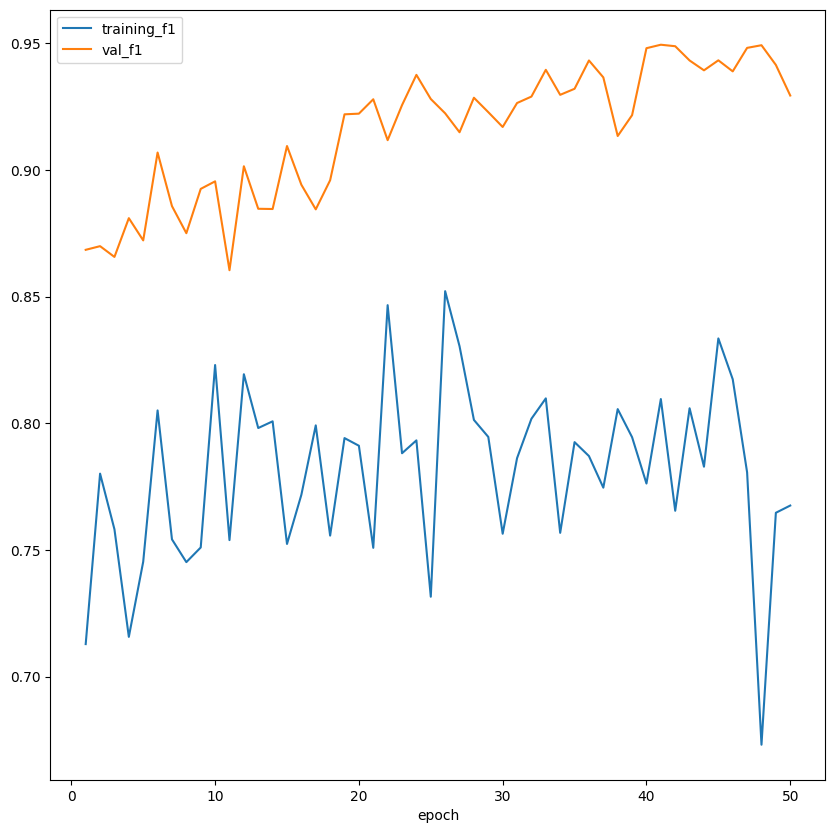

In [245]:
plt.rcParams['figure.figsize'] = [10, 10]
firstPlot = resultsDF.plot(x="epoch", y="training_f1")
resultsDF.plot(x='epoch', y="val_f1", ax=firstPlot)
plt.show()

## TESTING MODEL -> Spatial Predictions

In [246]:
model = smp.DeepLabV3Plus(
    encoder_name=encoder,
    encoder_weights=encoder_weights,
    classes=2,
    activation=activation,
)

In [247]:
model.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [248]:
model = model.to(device)

In [249]:
model.load_state_dict(torch.load('/content/Albania_model_Dlv3p.pt'))

<All keys matched successfully>

In [250]:
test_dataset = AlbaniaDataset(test, transform=None)

In [251]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

In [252]:
acc = tm.Accuracy(task="multiclass", num_classes=2).to(device)
f1 = tm.F1Score(task="multiclass", num_classes=2, average='none').to(device)
recall = tm.Recall(task="multiclass", num_classes=2, average='none').to(device)
precision = tm.Precision(task="multiclass", num_classes=2, average='none').to(device)
kappa = tm.CohenKappa(task="multiclass", num_classes=2).to(device)
cm = tm.ConfusionMatrix(task="multiclass", num_classes=2).to(device)

In [253]:
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [254]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        #loss_v = criterion(outputs, targets)
        accV = acc(outputs, targets)
        f1V = f1(outputs, targets)
        rV = recall(outputs, targets)
        pV = precision(outputs, targets)
        kappaV = kappa(outputs, targets)
        cmV = cm(outputs, targets)
accV = acc.compute()
f1V = f1.compute()
rV = recall.compute()
pV = precision.compute()
kappaV = kappa.compute()
cmV = cm.compute()
acc.reset()
f1.reset()
recall.reset()
precision.reset()
kappa.reset()
cm.reset()

In [255]:
print(accV)

tensor(0.9910, device='cuda:0')


In [256]:
print(f1V)

tensor([0.9952, 0.9095], device='cuda:0')


In [257]:
print(rV)

tensor([0.9937, 0.9376], device='cuda:0')


In [258]:
print(pV)

tensor([0.9968, 0.8831], device='cuda:0')


In [259]:
print(kappaV)

tensor(0.9048, device='cuda:0')


In [262]:
print(cmV)

tensor([[991470,   6305],
        [  3170,  47631]], device='cuda:0')


TEST

In [278]:
testImg = '/content/Albania3_2018-06-24.tiff'

In [279]:
def geoInfer(image_in, pred_out, chip_size, stride_x, stride_y, crop, n_channels):

    # Reading raster image

    image_source = rio.open(image_in)
    image1 = image_source.read()
    image_source.close
    image1 = image1[[1,2,3,4,5,6,7,8,9,10,11,12],:,:]
    image1 = image1.astype('float32')
    image1 = torch.from_numpy(image1)
    image1 = image1.float()/255
    t_arr = image1

    # Bland raster image

    image_source_2 = rio.open(image_in)
    image2 = image_source_2.read()
    image_source_2.close
    image2 = image2[[1,2,3,4,5,6,7,8,9,10,11,12],:,:]
    image2 = image2.astype('float32')
    image2 = torch.from_numpy(image2)
    image2 = image2.float()/255
    p_arr = image2[0, :, :]
    p_arr[:,:] = 0

    #Predict to entire topo using overlapping chips, merge back to original extent=============
    size = chip_size
    stride_x = stride_x
    stride_y = stride_y
    crop = crop
    n_channels = n_channels

    across_cnt = t_arr.shape[2]
    down_cnt = t_arr.shape[1]
    tile_size_across = size
    tile_size_down = size
    overlap_across = stride_x
    overlap_down = stride_y
    across = math.ceil(across_cnt/overlap_across)
    down = math.ceil(down_cnt/overlap_down)
    across_seq = list(range(0, across, 1))
    down_seq = list(range(0, down, 1))
    across_seq2 = [(x*overlap_across) for x in across_seq]
    down_seq2 = [(x*overlap_down) for x in down_seq]
    #Loop through row/column combinations to make predictions for entire image
    for c in across_seq2:
        for r in down_seq2:
            c1 = c
            r1 = r
            c2 = c + size
            r2 = r + size
            #Default
            if c2 <= across_cnt and r2 <= down_cnt:
                r1b = r1
                r2b = r2
                c1b = c1
                c2b = c2
            #Last column
            elif c2 > across_cnt and r2 <= down_cnt:
                r1b = r1
                r2b = r2
                c1b = across_cnt - size
                c2b = across_cnt + 1
            #Last row
            elif c2 <= across_cnt and r2 > down_cnt:
                r1b = down_cnt - size
                r2b = down_cnt + 1
                c1b = c1
                c2b = c2
            #Last row, last column
            else:
                c1b = across_cnt - size
                c2b = across_cnt + 1
                r1b = down_cnt - size
                r2b = down_cnt + 1
            ten1 = t_arr[0:n_channels, r1b:r2b, c1b:c2b]
            ten1 = ten1.to(device).unsqueeze(0)
            model.eval()
            with torch.no_grad():
              ten2 = model(ten1)
            m = nn.Softmax(dim=1)
            pr_probs = m(ten2)
            ten_p = torch.argmax(pr_probs, dim=1).squeeze(1)
            ten_p = ten_p.squeeze()
            #print("executed for " + str(r1) + ", " + str(c1))
            if(r1b == 0 and c1b == 0): #Write first row, first column
                p_arr[r1b:r2b-crop, c1b:c2b-crop] = ten_p[0:size-crop, 0:size-crop]
            elif(r1b == 0 and c2b == across_cnt+1): #Write first row, last column
                p_arr[r1b:r2b-crop, c1b+crop:c2b] = ten_p[0:size-crop, 0+crop:size]
            elif(r2b == down_cnt+1 and c1b == 0): #Write last row, first column
                p_arr[r1b+crop:r2b, c1b:c2b-crop] = ten_p[crop:size+1, 0:size-crop]
            elif(r2b == down_cnt+1 and c2b == across_cnt+1): #Write last row, last column
                p_arr[r1b+crop:r2b, c1b+crop:c2b] = ten_p[crop:size, 0+crop:size+1]
            elif((r1b == 0 and c1b != 0) or (r1b == 0 and c2b != across_cnt+1)): #Write first row
                p_arr[r1b:r2b-crop, c1b+crop:c2b-crop] = ten_p[0:size-crop, 0+crop:size-crop]
            elif((r2b == down_cnt+1 and c1b != 0) or (r2b == down_cnt+1 and c2b != across_cnt+1)): # Write last row
                p_arr[r1b+crop:r2b, c1b+crop:c2b-crop] = ten_p[crop:size, 0+crop:size-crop]
            elif((c1b == 0 and r1b !=0) or (c1b ==0 and r2b != down_cnt+1)): #Write first column
                p_arr[r1b+crop:r2b-crop, c1b:c2b-crop] = ten_p[crop:size-crop, 0:size-crop]
            elif (c2b == across_cnt+1 and r1b != 0) or (c2b == across_cnt+1 and r2b != down_cnt+1): # write last column
                p_arr[r1b+crop:r2b-crop, c1b+crop:c2b] = ten_p[crop:size-crop, 0+crop:size]
            else: #Write middle chips
                p_arr[r1b+crop:r2b-crop, c1b+crop:c2b-crop] = ten_p[crop:size-crop, crop:size-crop]

    #Read in a GeoTIFF to get CRS info=======================================
    image3 = rio.open(image_in)
    profile1 = image3.profile.copy()
    image3.close()
    profile1["driver"] = "GTiff"
    profile1["dtype"] = "uint8"
    profile1["count"] = 1
    profile1["PHOTOMETRIC"] = "MINISBLACK"
    profile1["COMPRESS"] = "NONE"

    pr_out = p_arr.cpu().numpy().round().astype('uint8')

    #Write out result========================================================
    with rio.open(pred_out, "w", **profile1) as f:
        f.write(pr_out,1)

    torch.cuda.empty_cache()

In [280]:
geoInfer(image_in=testImg,
    pred_out=saveFolder + "predicted_mask.tif",
    chip_size=256, stride_x=128, stride_y=128, crop=50, n_channels=12)